# Project for UDA Assessment 4
## Author: 02179784 (Mark Roberts)

<B>Project Description:</B><BR>
The objective of this project is to create a simple framework to test how well image classification models perform when presented with degraded images.  The idea is that different classification models can be swapped-in/out and tested with minimal changes.  Also, the type of image degradation - e.g. faded or noisy images - can be easily changed.

In this particular implementation of the framework:
 - we use a model that has been pre-trained to classify non-degraded images with an accurancy of over 97%.<BR>
    This model was created using the guidance provided in chapter 8 of [1], and is based on refining an already pretrained model.<BR>
    The refining of the model has been omitted here as it took several hours to build this model!
 - all images used in the refining and testing of this model are cat and dog images taken from the Kaggle website: [Cat and Dog Images](https://kaggle.com/competitions/dogs-vs-cats/data).
 - testing will be performed using two types of image degradation:
    1. uniform random noise, but this could be easily replaced by other noise patterns (e.g. Gaussian) if desired and
    2. image fading, which is simulated by colour strength reduction.
 
The testing image dataset consists of 2000 images - 1000 cat and 1000 dog images.


<B>General Information:</B><BR>
 - This script was run on a Macbook Pro. with 16 GB of RAM, 3.1 GHz Quad-Core Intel Core i7.
 - The total run time of the Jupyter notebook was (approx) 2 hours.
 - The Github repository for all code and datasets can be obtained by cloning the repository:<BR>
              https://github.com/Mark12481632/UDA_Assessment_4_02179784_Roberts.git
 - The model used to classify the images is built on __TensorFlow__ and __Keras__.
 - __Altered images need to be saved to disk - so write permission for the notebook is required!!__
    
<B>References:</B><BR>
    
    [1] - Deep Learning with Python (Francios Chollet, Manning Publications, ISBN-13: 978-1617296864)

In [2]:
# Load in the required libraries

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers, Input, Model, Sequential
from keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from skimage import io

2022-12-29 10:38:17.277537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Location of non-noisy and noisy images:
test_dir = "./cats_vs_dogs/test"
test_altered_dir = "./cats_vs_dogs/test_altered"

test_dataset = image_dataset_from_directory(test_dir, image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.


2022-12-29 10:38:21.996112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# variables that store accuracy and level of noise/fading in images
noise_level = []
noise_accuracy = []
sample_noisy_image = []

In [5]:
# Test on Original images without any noise.
# The image that was trained has been saved as "feature_extraction_with_data_augmentation.keras"

test_model = load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

noise_level.append(0)                                          # Noise level saved
noise_accuracy.append(round(test_acc, 4))                            # Model accuracy saved
sample_noisy_image.append(io.imread(test_dir + "/cat/cat.1500.jpg")) # Sample image saved

63/63 [==============================] - 155s 2s/step - loss: 3.5702 - accuracy: 0.9755


In [6]:
def create_noisy_image(src_img, dst_img, noise_level):
    """
    This function takes a single image 'src_img' and addes noise to it as defoned
    by the 'noise_level' parameter.  The noisy image is then written to 'dst_img'.
    Nothing is returned.
    """
    # Read in image into Numpy array
    img = io.imread(src_img)

    # Generate a matrix of random data (0=>1) in same shape as image
    noise_matrix = np.random.uniform(low=0, high=1.0,
                                     size=(img.shape[0]*img.shape[1])).reshape(img.shape[0], img.shape[1])
    # Where does the data exceed the "threshold"
    noise_matrix = np.where(noise_matrix < noise_level)

    # Remove colours from image at the given random points
    for (x,y) in zip(noise_matrix[0], noise_matrix[1]):
        img[x, y, 0:3] = 0

    # Save the image
    io.imsave(dst_img, img)


def fade_image(src_img, dst_img, fade_level):
    """
    """
    # Read in image into Numpy array
    img = io.imread(src_img)

    # Fade image by reducing all colours by given factor
    img = np.uint8(img * fade_level)

    # Save the image
    io.imsave(dst_img, img)



def create_altered_images(src_dir, dst_dir, ftn, level):
    """
    This function copies over the images from a 'src_dir' to a 'dst_dir' after performing some
    function on them - e.g. adding noise or fading the image.  The 'level' determines the degree/level
    of noise (0->1) or fade (0->1).
    Nothing is returned.
    """
    all_cats = os.listdir(src_dir + "/cat")
    all_dogs = os.listdir(src_dir + "/dog")

    for cat in all_cats:
        ftn(src_dir + "/cat/" + cat, dst_dir + "/cat/" + cat, level)

    for dog in all_dogs:
        ftn(src_dir + "/dog/" + dog, dst_dir + "/dog/" + dog, level)

In [7]:
# Now we apply the model to varying levels of noise in the image.
# Noise profile - defined noise level at each step - shoul be between 0 and 1.0.
noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
                
for lvl in noise_levels:
    print(f"DEBUG: 1. Processing noise level:{lvl}")

    np.random.seed(2179784)  # To ensure reproducible.

    # Step 1: Clear out the ./cats_vs_dogs/test_noisy directories
    os.system('rm ./cats_vs_dogs/test_altered/cat/*.jpg')
    os.system('rm ./cats_vs_dogs/test_altered/dog/*.jpg')

    print("DEBUG: 2. Creating Images")

    # Step 2: Copy over the image after adding noise and setup as dataset
    create_altered_images(test_dir, test_altered_dir, create_noisy_image, lvl)
    test_noisy_dataset = image_dataset_from_directory(test_altered_dir, image_size=(180, 180), batch_size=32)

    print("DEBUG: 3. Save sample image")

    # Step 3: Save example image
    sample_noisy_image.append(io.imread(test_altered_dir + "/cat/cat.1500.jpg"))

    print("DEBUG: 4. Running Model")

    # Step 4: Run model against images
    test_loss, test_acc = test_model.evaluate(test_noisy_dataset)

    print("DEBUG: 5. Save Results")

    # Step 5: Save results
    noise_level.append(lvl)              # Noise level saved
    noise_accuracy.append(round(test_acc, 4))  # Model accuracy saved


DEBUG: 1. Processing noise level:0.05
DEBUG: 2. Creating Images


rm: ./cats_vs_dogs/test_altered/dog/*.jpg: No such file or directory


Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 155s 2s/step - loss: 13.5091 - accuracy: 0.9185
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.1
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 154s 2s/step - loss: 22.8581 - accuracy: 0.8650
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.15
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 2015s 32s/step - loss: 31.7887 - accuracy: 0.8295
DEBUG: 5. Save Results
DEBUG: 1. Processing noise level:0.2
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 151s 2s/step - loss: 39.7307 - accuracy: 0.7935
DEBUG: 5. S

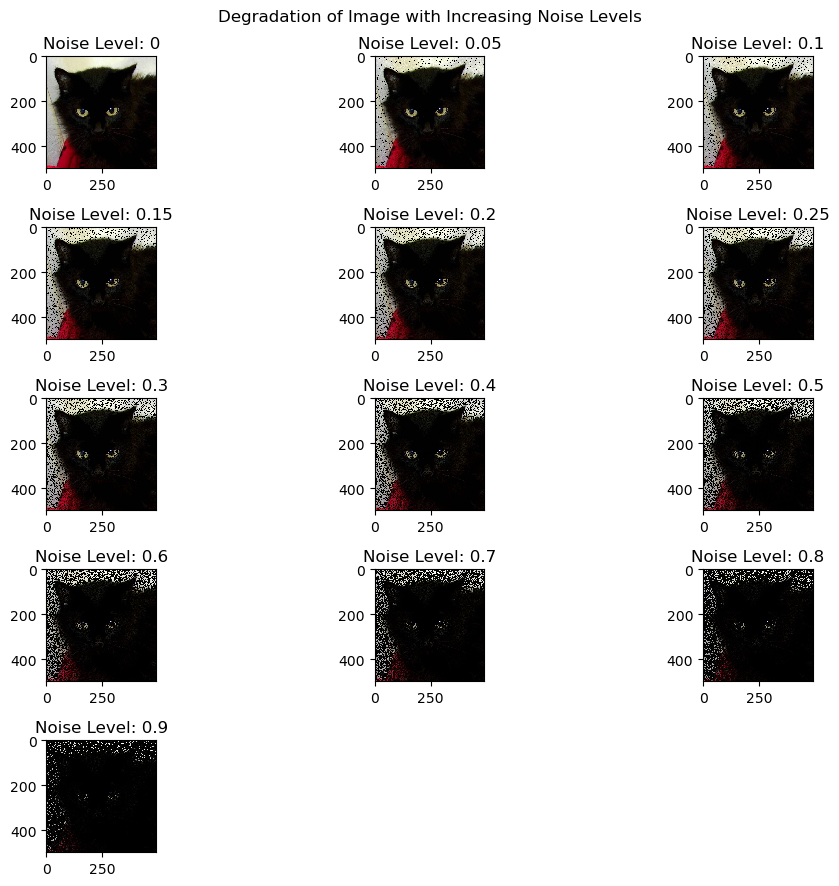

In [8]:
# Display sample images with varying degrees of noise

fig = plt.figure(figsize=(10, 9))
fig.suptitle('Degradation of Image with Increasing Noise Levels')
for i in range(len(sample_noisy_image)):
    ax = fig.add_subplot(5, 3, i+1)
    ax.set_title(f"Noise Level: {noise_level[i]}")
    io.imshow(sample_noisy_image[i])

(0.5, 1.0)

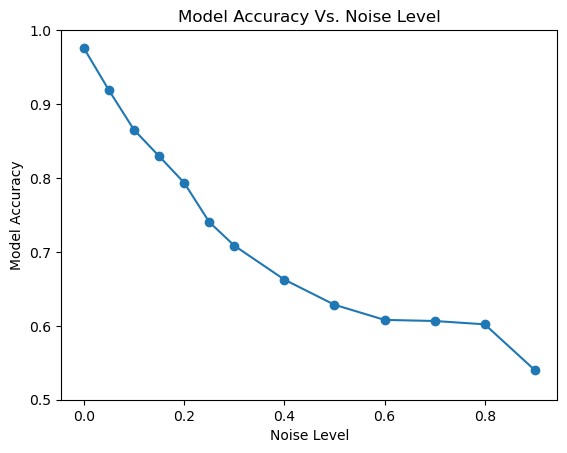

In [20]:
# Display the results of the effect of noise on the model's ability to classify images.

plt.plot(noise_level, noise_accuracy, '-o')
plt.xlabel("Noise Level")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy Vs. Noise Level")
plt.ylim(0.5, 1)

## Now Start the Fading Section

In [10]:
# Reset saved values:
fade_factor = []
fade_accuracy = []
sample_fade_image = []

In [11]:
# Now we apply the model to varying levels of faded image.
# Fade levels:
fade_levels = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
                
for lvl in fade_levels:
    print(f"DEBUG: 1. Processing fade level:{lvl}")

    np.random.seed(2179784)  # To ensure reproducible.

    # Step 1: Clear out the ./cats_vs_dogs/test_noisy directories
    os.system('rm ./cats_vs_dogs/test_altered/cat/*.jpg')
    os.system('rm ./cats_vs_dogs/test_altered/dog/*.jpg')

    print("DEBUG: 2. Creating Images")

    # Step 2: Copy over the image after adding noise and setup as dataset
    create_altered_images(test_dir, test_altered_dir, fade_image, lvl)
    test_faded_dataset = image_dataset_from_directory(test_altered_dir, image_size=(180, 180), batch_size=32)

    print("DEBUG: 3. Save sample image")

    # Step 3: Save example image
    sample_fade_image.append(io.imread(test_altered_dir + "/cat/cat.1500.jpg"))

    print("DEBUG: 4. Running Model")

    # Step 4: Run model against images
    test_loss, test_acc = test_model.evaluate(test_faded_dataset)

    print("DEBUG: 5. Save Results")

    # Step 5: Save results
    fade_factor.append(lvl)              # Fading level saved
    fade_accuracy.append(round(test_acc, 4))  # Model accuracy saved

DEBUG: 1. Processing fade level:1.0
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 2654s 43s/step - loss: 3.6433 - accuracy: 0.9750
DEBUG: 5. Save Results
DEBUG: 1. Processing fade level:0.9
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 163s 3s/step - loss: 3.4070 - accuracy: 0.9745
DEBUG: 5. Save Results
DEBUG: 1. Processing fade level:0.8
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 164s 3s/step - loss: 3.2908 - accuracy: 0.9730
DEBUG: 5. Save Results
DEBUG: 1. Processing fade level:0.7
DEBUG: 2. Creating Images
Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 164s

/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.1548.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.2486.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.1511.jpg is a low contrast image
  io.imsave(dst_img, img)


Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 209s 3s/step - loss: 4.1099 - accuracy: 0.9610
DEBUG: 5. Save Results
DEBUG: 1. Processing fade level:0.2
DEBUG: 2. Creating Images


/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.1576.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.2087.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.2253.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.1943.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000gn/T/ipykernel_74550/1528259583.py:34: UserWarning: ./cats_vs_dogs/test_altered/cat/cat.1846.jpg is a low contrast image
  io.imsave(dst_img, img)
/var/folders/pm/qn6ytz3x4hn6_8dbh2l8dk6m0000g

Found 2000 files belonging to 2 classes.
DEBUG: 3. Save sample image
DEBUG: 4. Running Model
63/63 [==============================] - 166s 3s/step - loss: 4.3022 - accuracy: 0.9485
DEBUG: 5. Save Results


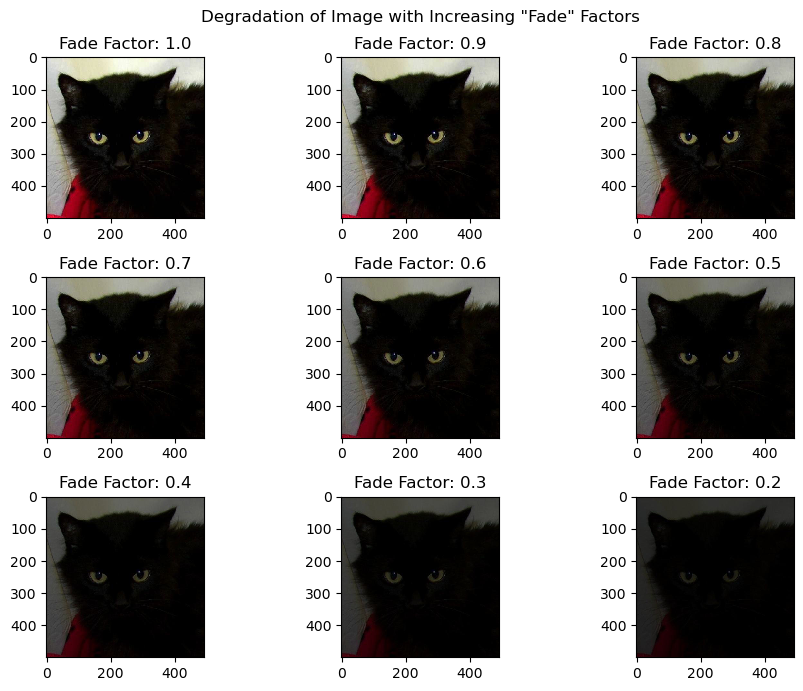

In [12]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle('Degradation of Image with Increasing "Fade" Factors')
for i in range(len(sample_fade_image)):
    ax = fig.add_subplot(4, 3, i+1)
    ax.set_title(f"Fade Factor: {fade_factor[i]}")
    io.imshow(sample_fade_image[i])

(0.5, 1.0)

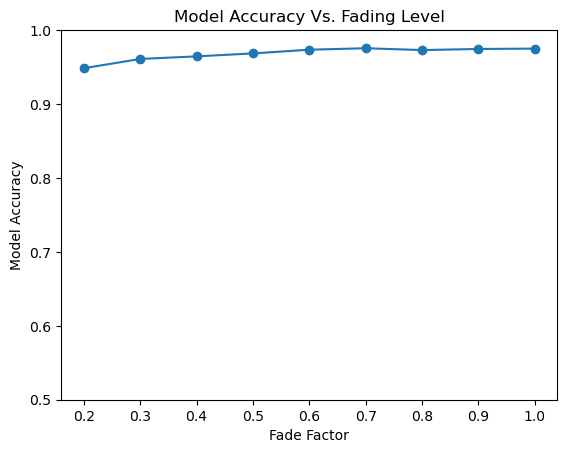

In [19]:
# Display the results of the effect of fading on the model's ability to classify images.

plt.plot(fade_factor, fade_accuracy, '-o')
plt.xlabel("Fade Factor")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy Vs. Fading Level")
plt.ylim(0.5, 1)